# Fine-tuning MobileNetV2 for image classification

## Michał Gromadzki

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
tf.random.set_seed(1337)
np.random.seed(1337)

2023-05-24 01:30:10.349778: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-24 01:30:12.711638: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/majkel/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#load data
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

2023-05-24 01:30:19.144383: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-24 01:30:19.452649: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-24 01:30:19.452850: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-24 01:30:19.460356: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-24 01:30:19.460688: I tensorflow/compile

In [3]:
num_classes = metadata.features['label'].num_classes
num_classes

5

2023-05-24 01:30:23.475085: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [2]
	 [[{{node Placeholder/_1}}]]
2023-05-24 01:30:23.476333: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2]
	 [[{{node Placeholder/_0}}]]
2023-05-24 01:30:23.735033: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline 

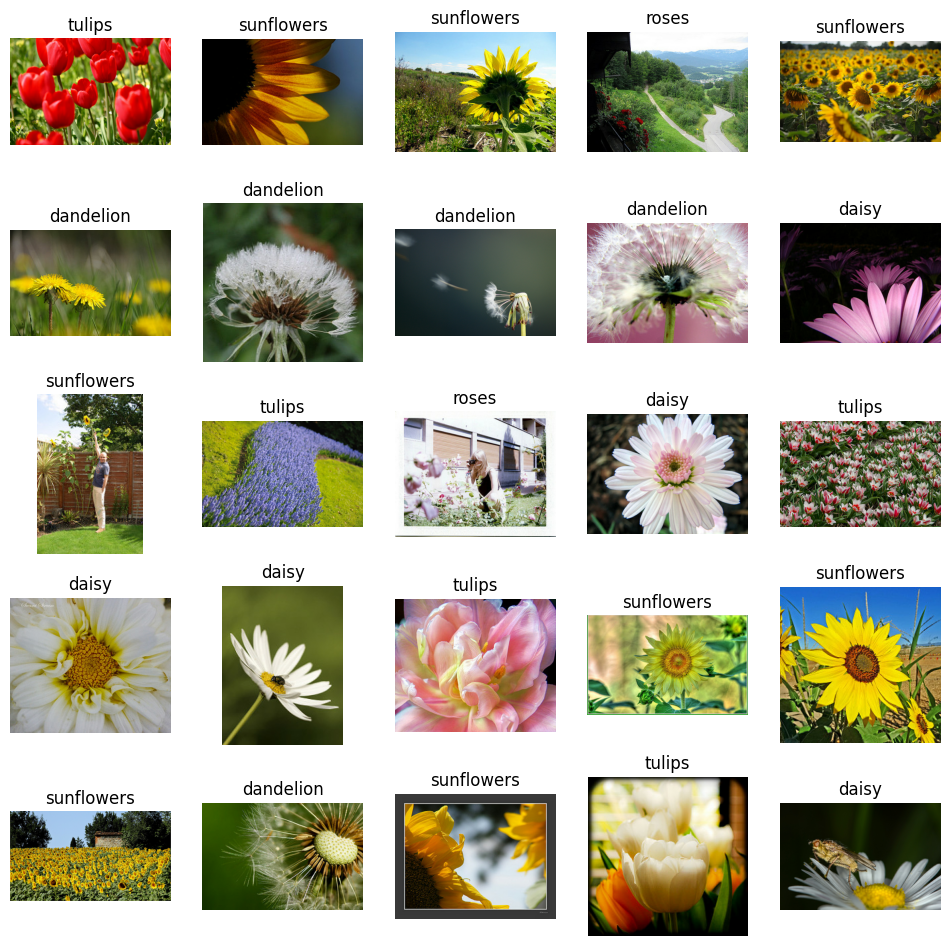

In [4]:
get_label_name = metadata.features['label'].int2str
fig, axes = plt.subplots(5, 5, figsize=(12,12))
for ax, (image, label) in zip(axes.flat,train_ds.take(25)):
    ax.imshow(image)
    ax.set_title(get_label_name(label))
    ax.axis('off')
plt.show()

## Preprocessing

In [5]:
IMG_SIZE = 160
preproc = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE),
  tf.keras.layers.Rescaling(scale=1./127.5, offset=-1),
])

In [6]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE
def preproc_dataset(dataset):
    dataset = dataset.map(lambda x, y: (preproc(x), y)).shuffle(1024).batch(batch_size)
    return dataset

In [7]:
train_ds_preproc = preproc_dataset(train_ds)
val_ds_preproc = preproc_dataset(val_ds)
test_ds_preproc = preproc_dataset(test_ds)

## Model

In [8]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
])

In [9]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [10]:
base_model.trainable = False

In [11]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [12]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(num_classes, activation="softmax")
mid_layer = tf.keras.layers.Dense(128, activation="relu")

In [13]:
IMG_SHAPE

(160, 160, 3)

In [14]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = mid_layer(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 128)               163968

In [16]:
learning_rate = 1e-4
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])

In [17]:
history = model.fit(train_ds_preproc,epochs=10,validation_data=val_ds_preproc)

Epoch 1/10


2023-05-24 01:30:31.566707: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [2]
	 [[{{node Placeholder/_2}}]]
2023-05-24 01:30:31.567533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [2]
	 [[{{node Placeholder/_2}}]]
2023-05-24 01:30:39.515270: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-05-24 01:30:45.573613: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x21a2e6a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-24 

92/92 [==============================] - ETA: 0s - loss: 1.3538 - accuracy: 0.4782

2023-05-24 01:31:14.245008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2023-05-24 01:31:14.245697: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]


92/92 [==============================] - 49s 377ms/step - loss: 1.3538 - accuracy: 0.4782 - val_loss: 0.8702 - val_accuracy: 0.7084
Epoch 2/10
92/92 [==============================] - 26s 281ms/step - loss: 0.7284 - accuracy: 0.7435 - val_loss: 0.6184 - val_accuracy: 0.7984
Epoch 3/10
92/92 [==============================] - 25s 267ms/step - loss: 0.5698 - accuracy: 0.7888 - val_loss: 0.5191 - val_accuracy: 0.8256
Epoch 4/10
92/92 [==============================] - 26s 275ms/step - loss: 0.4888 - accuracy: 0.8225 - val_loss: 0.4721 - val_accuracy: 0.8420
Epoch 5/10
92/92 [==============================] - 17s 185ms/step - loss: 0.4554 - accuracy: 0.8454 - val_loss: 0.4240 - val_accuracy: 0.8447
Epoch 6/10
92/92 [==============================] - 19s 205ms/step - loss: 0.4271 - accuracy: 0.8532 - val_loss: 0.4128 - val_accuracy: 0.8447
Epoch 7/10
92/92 [==============================] - 18s 189ms/step - loss: 0.3739 - accuracy: 0.8661 - val_loss: 0.3845 - val_accuracy: 0.8583
Epoch 8/10

In [18]:
loss, acc = model.evaluate(test_ds_preproc)
acc

2023-05-24 01:34:24.141865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-05-24 01:34:24.143080: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]


12/12 [==============================] - 2s 139ms/step - loss: 0.3296 - accuracy: 0.8856


0.8855586051940918

In [19]:
base_model.trainable = True

In [20]:
for layer in base_model.layers[:120]:
    layer.trainable = False

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 128)               163968

In [22]:
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate/10),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [23]:
history2 = model.fit(train_ds_preproc,epochs=20,validation_data=val_ds_preproc,initial_epoch=history.epoch[-1])

Epoch 10/20
92/92 [==============================] - 36s 241ms/step - loss: 0.3319 - accuracy: 0.8774 - val_loss: 0.3364 - val_accuracy: 0.8883
Epoch 11/20
92/92 [==============================] - 17s 179ms/step - loss: 0.2986 - accuracy: 0.8886 - val_loss: 0.3467 - val_accuracy: 0.8665
Epoch 12/20
92/92 [==============================] - 22s 231ms/step - loss: 0.2664 - accuracy: 0.8975 - val_loss: 0.2971 - val_accuracy: 0.8992
Epoch 13/20
92/92 [==============================] - 23s 243ms/step - loss: 0.2624 - accuracy: 0.9046 - val_loss: 0.2993 - val_accuracy: 0.9019
Epoch 14/20
92/92 [==============================] - 23s 242ms/step - loss: 0.2517 - accuracy: 0.9057 - val_loss: 0.2958 - val_accuracy: 0.8965
Epoch 15/20
92/92 [==============================] - 21s 230ms/step - loss: 0.2315 - accuracy: 0.9179 - val_loss: 0.2913 - val_accuracy: 0.9019
Epoch 16/20
92/92 [==============================] - 21s 223ms/step - loss: 0.2120 - accuracy: 0.9189 - val_loss: 0.2763 - val_accuracy:

In [24]:
loss, acc = model.evaluate(test_ds_preproc)
acc

12/12 [==============================] - 2s 116ms/step - loss: 0.2522 - accuracy: 0.9046


0.9046321511268616

## Learning plot

In [25]:
acc = history.history['accuracy'] + history2.history['accuracy']
val_acc = history.history['val_accuracy'] + history2.history['val_accuracy']

loss = history.history['loss'] + history2.history['loss']
val_loss = history.history['val_loss'] + history2.history['val_loss']

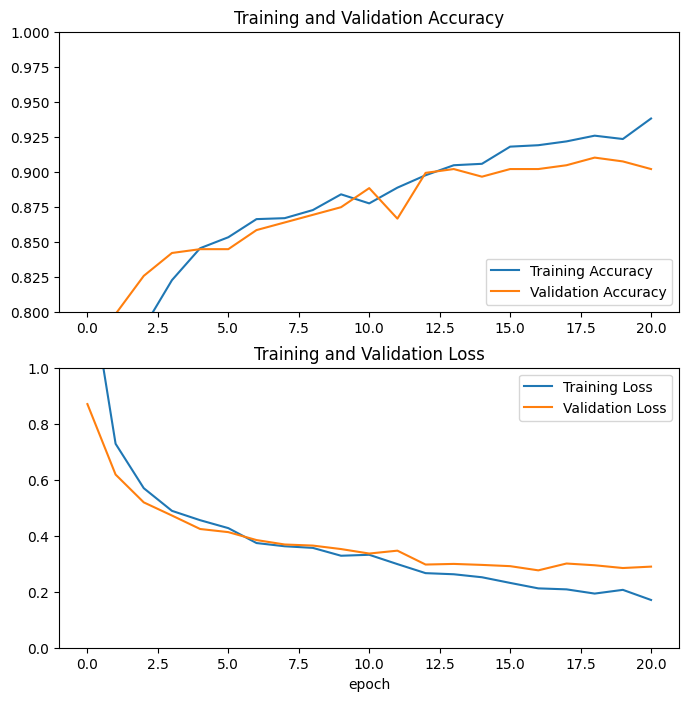

In [26]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Examples

2023-05-24 01:38:36.451513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-05-24 01:38:36.452207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]


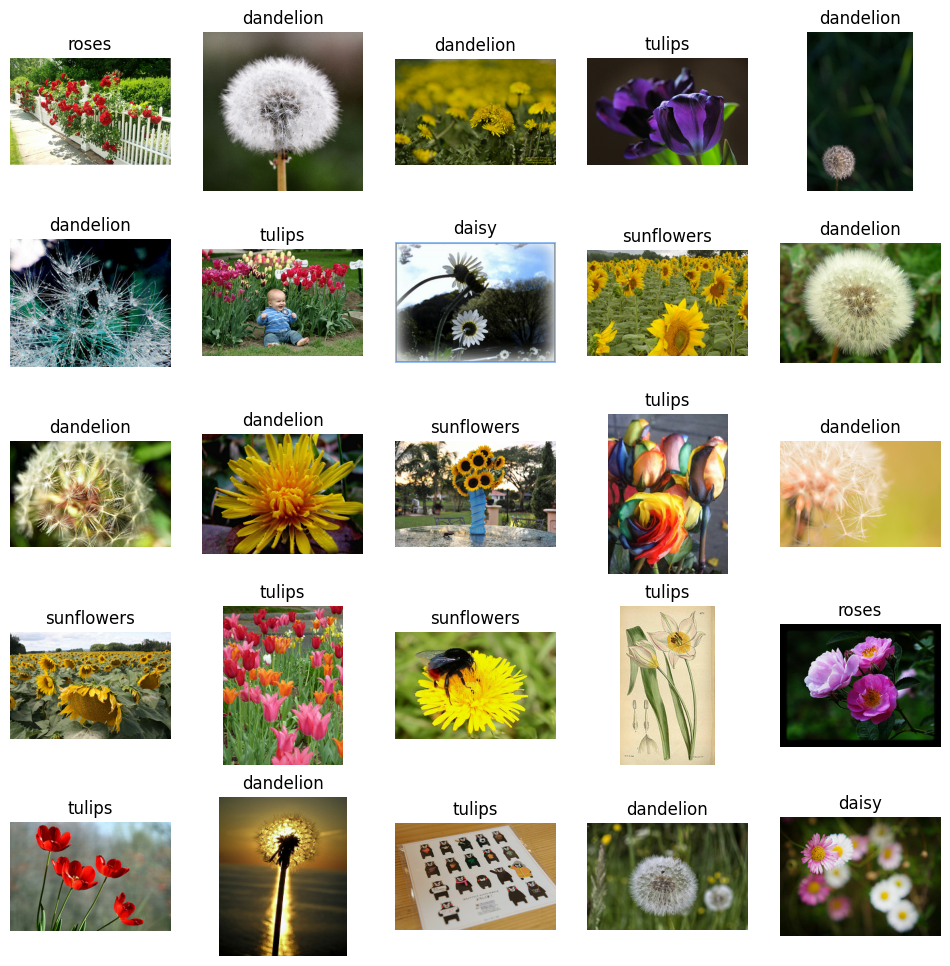

In [27]:
fig, axes = plt.subplots(5, 5, figsize=(12,12))
for ax, (image, label) in zip(axes.flat,test_ds.take(25)):
    ax.imshow(image)
    image_preproc = tf.expand_dims(preproc(image),0)
    pred = model.predict(image_preproc, verbose=0)
    pred = np.argmax(pred)
    ax.set_title(get_label_name(pred))
    ax.axis('off')
plt.show()

## Fresh model for comparison

In [28]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu',input_shape=(IMG_SIZE, IMG_SIZE, 3)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes),
  tf.keras.layers.Dropout(0.2)
])

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 160, 160, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 80, 80, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 80, 80, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 40, 40, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 40, 40, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 20, 20, 64)      

In [30]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

In [31]:
model.fit(train_ds_preproc, epochs=8,validation_data=val_ds_preproc)

Epoch 1/8
92/92 [==============================] - 13s 87ms/step - loss: 1.3170 - accuracy: 0.4503 - val_loss: 1.0109 - val_accuracy: 0.5777
Epoch 2/8
92/92 [==============================] - 7s 68ms/step - loss: 1.0488 - accuracy: 0.5691 - val_loss: 0.9142 - val_accuracy: 0.6485
Epoch 3/8
92/92 [==============================] - 7s 68ms/step - loss: 0.8350 - accuracy: 0.6754 - val_loss: 0.8759 - val_accuracy: 0.6594
Epoch 4/8
92/92 [==============================] - 7s 68ms/step - loss: 0.6692 - accuracy: 0.7435 - val_loss: 0.8745 - val_accuracy: 0.6703
Epoch 5/8
92/92 [==============================] - 6s 68ms/step - loss: 0.4851 - accuracy: 0.8123 - val_loss: 1.0712 - val_accuracy: 0.6431
Epoch 6/8
92/92 [==============================] - 7s 69ms/step - loss: 0.3323 - accuracy: 0.8682 - val_loss: 1.1118 - val_accuracy: 0.6594
Epoch 7/8
92/92 [==============================] - 7s 69ms/step - loss: 0.2497 - accuracy: 0.8961 - val_loss: 1.3767 - val_accuracy: 0.6267
Epoch 8/8
92/92 [==

In [32]:
loss, acc = model.evaluate(test_ds_preproc)
acc #~20% difference

12/12 [==============================] - 0s 21ms/step - loss: 1.2336 - accuracy: 0.6975


0.6975476741790771

# Final version in model.py